In [56]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from chainer import cuda, Variable, FunctionSet, optimizers
import chainer.functions as F
from sklearn.cross_validation import train_test_split
import sys
import csv
from pprint import pprint 

plt.style.use('ggplot')


In [57]:
# 確率的勾配降下法におけるミニバッチ数
batchsize = 20

# 学習の繰り返し回数
n_epoch = 100

# 中間層の数
n_units = 15


#=================================================
# csvファイルからデータを取り出し、listに格納
def set_data():

        filename = "../../../data/secondary_selection/input_data_2_except_evaluation"
        
        f = open('%s.csv' % filename, 'rU')
        data = csv.reader(f)

        data_set = []
        target_set = []
        for line in data:
                data_set.append(line[1:10])
                target_set.append(line[10])
        f.close()
        np_dataSet = np.array(data_set, dtype=np.float32)
        np_targetSet = np.array(target_set, dtype=np.int32)
        return np_dataSet, np_targetSet

#=================================================

data, target = set_data()

# <!--- start_debug
#print data.shape
#print target.shape
#       end_debug ----> 


# 学習用データをN個、検証用データを残りの個数と設定
# Nの値は暫定的なもの
#N = 300
#x_train, x_test = np.split( data, [N])  
#y_train, y_test = np.split( target, [N]) 
#N_test = y_test.size
#print data
#print target



In [58]:
# 多層パーセプトロンモデルの設定
# 入力 9次元、出力 2次元
model = FunctionSet(l1=F.Linear(9, n_units),
                    l2=F.Linear(n_units, 2))

# Neural net architecture
# ニューラルネットの構造
def forward(x_data, y_data, train=True ):
        x, t = Variable(x_data), Variable(y_data)
        h1 = F.dropout(F.relu(model.l1(x)), ratio=.5, train=train)
        y = model.l2(h1)
        # 0/1の2クラス分類なので誤差関数として、ソフトマックス関数
        # を用いて、誤差を導出
   
                                
        #print '-'*50
        #print ' h3'
        #print '-'*50
        #print vars(h3)
                        
        #print '-'*50
        #print ' y'
        #print '-'*50
        #print vars(y)
 
        
        return F.softmax_cross_entropy(y, t), F.accuracy(y, t), F.recall(y, t), F.precision(y, t)



In [59]:
# Setup optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)

train_loss = []
train_acc= []
train_rec = []
train_pre = []
test_loss = []
test_acc = []
test_rec = []
test_pre = []

l1_W = []
l2_W = []



[]

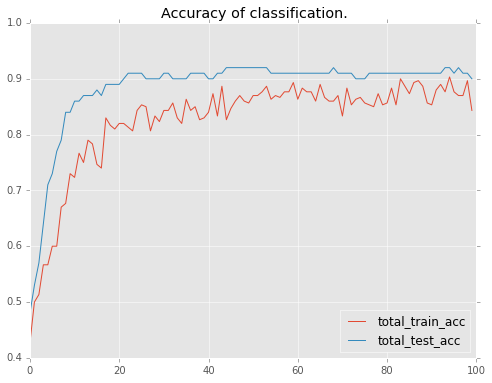

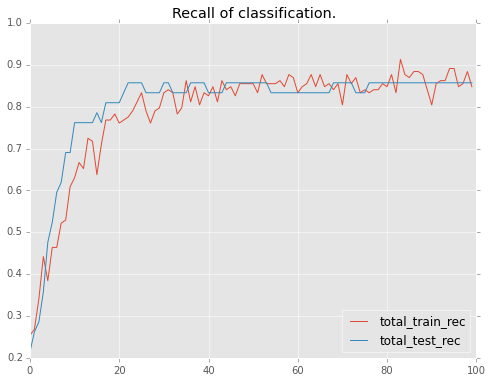

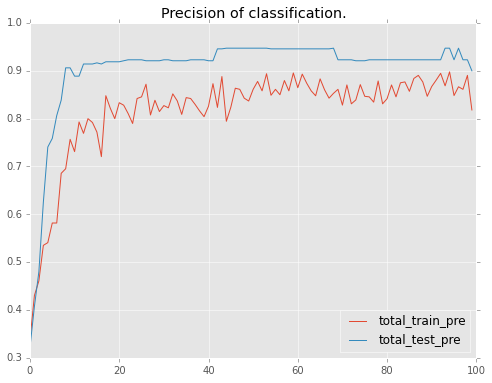

In [60]:
##インプットデータ総数
#n_kf = 400
##fold数
#n_kf_folds = 4
##trainデータ数
#N = n_kf  *  (( n_kf_folds-1)*1.0 / n_kf_folds)
#N = int(N)
##testデータ数
#N_test = n_kf - N

#cv配列初期化
#total_train_loss = [0] * n_epoch
#total_train_acc = [0] * n_epoch
#total_train_rec = [0] * n_epoch
#total_train_pre = [0] * n_epoch
#total_test_loss = [0] * n_epoch


total_train_loss = []
total_train_acc = []
total_train_rec = []
total_train_pre = []
total_test_loss = []
total_test_acc = []
total_test_rec = []
total_test_pre = []




x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)

train_size = x_train.T[0].size
test_size = x_test.T[0].size

#print kf_train_index[perm[0:15]]
    
#print kf_train_index
    
# Learning loop
for epoch in xrange(1, n_epoch+1):
    #print 'epoch', epoch

    # training
    # N個の順番をランダムに並び替える
    perm = np.random.permutation(train_size)
    sum_accuracy = 0
    sum_loss = 0
    sum_recall = 0
    sum_precision = 0
    total_rec_size = 0
    total_pre_size = 0
    # 0〜Nまでのデータをバッチサイズごとに使って学習
    for i in xrange(0, train_size, batchsize):
        x_batch = x_train[perm[i:i+batchsize]]
        y_batch = y_train[perm[i:i+batchsize]]
        # 勾配を初期化
        optimizer.zero_grads()
        # 順伝播させて誤差と精度を算出
        loss, acc, rec, pre = forward(x_batch, y_batch)
        # 誤差逆伝播で勾配を計算
        loss.backward()
        optimizer.update()
        
        sum_loss += float(cuda.to_cpu(loss.data)) * batchsize
        sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize
        sum_recall += float(cuda.to_cpu(rec.data[0])) * rec.data[1]
        sum_precision += float(cuda.to_cpu(pre.data[0])) * pre.data[1]
        total_rec_size += rec.data[1]
        total_pre_size += pre.data[1]
        
        #print rec.data[0]
        #print rec.data[1]
                    
                    
                    
    # 訓練データの誤差と、正解精度を表示
    #print 'train mean loss={}, accuracy={}, recall={}, precision={}'.format(sum_loss / N, sum_accuracy / N, sum_recall / N, sum_precision / N)
                
    total_train_loss.append(sum_loss / train_size)
    total_train_acc.append(sum_accuracy / train_size)
    total_train_rec.append(sum_recall / total_rec_size)
    total_train_pre.append(sum_precision / total_pre_size)


    # evaluation
    # テストデータで誤差と、正解精度を算出し汎化性能を確認
    sum_accuracy = 0
    sum_loss     = 0
    sum_recall = 0
    sum_precision = 0
    total_rec_size = 0
    total_pre_size = 0
    for i in xrange(0, test_size, batchsize):
        x_batch = x_test[i:i+batchsize]
        y_batch = y_test[i:i+batchsize]

        # 順伝播させて誤差と精度を算出
        loss, acc, rec, pre = forward(x_batch, y_batch, train=False)
          
        #print( cuda.to_cpu(loss.data))
        #print( cuda.to_cpu(rec.data))
        #print( cuda.to_cpu(pre.data))
        sum_loss     += float(cuda.to_cpu(loss.data)) * batchsize
        sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize
        sum_recall += float(cuda.to_cpu(rec.data[0])) * rec.data[1]
        sum_precision += float(cuda.to_cpu(pre.data[0])) * pre.data[1]
        total_rec_size += rec.data[1]
        total_pre_size += pre.data[1]
        
        #print rec.data[0]
        #print rec.data[1]
                

            # テストデータでの誤差と、正解精度を表示
            #print 'test  mean loss={}, accuracy={}, recall={}, precision={}'.format(sum_loss / N_test, sum_accuracy / N_test, sum_recall / N_test, sum_precision / N_test)
            #test_loss.append( sum_loss / N_test)
            #test_acc.append( sum_accuracy / N_test)
            #test_rec.append(sum_recall / N_test)
            #test_pre.append(sum_precision / N_test) 
            
            
    total_test_loss.append(sum_loss / test_size)
    total_test_acc.append(sum_accuracy / test_size)
    total_test_rec.append(sum_recall / total_rec_size)
    total_test_pre.append(sum_precision / total_pre_size)
        

        
    # 学習したパラメーターを保存
    l1_W.append(model.l1.W)
    l2_W.append(model.l2.W)
        
            #l1_W = np.append( l1_W, model.l1.W)
        
                      
            #pprint(vars(model.l1))
            #pprint(model.l1.W[0:2])

        
            
# 精度と誤差をグラフ描画
plt.figure(figsize=(8,6))
plt.plot(range(len(total_train_acc)), total_train_acc)
plt.plot(range(len(total_test_acc)), total_test_acc)
plt.legend(["total_train_acc","total_test_acc"],loc=4)
plt.title("Accuracy of classification.")
plt.plot()


plt.figure(figsize=(8,6))
plt.plot(range(len(total_train_rec)), total_train_rec)
plt.plot(range(len(total_test_rec)), total_test_rec)
plt.legend(["total_train_rec","total_test_rec"],loc=4)
plt.title("Recall of classification.")
plt.plot()


plt.figure(figsize=(8,6))
plt.plot(range(len(total_train_pre)), total_train_pre)
plt.plot(range(len(total_test_pre)), total_test_pre)
plt.legend(["total_train_pre","total_test_pre"],loc=4)
plt.title("Precision of classification.")
plt.plot()

In [61]:
print total_test_acc[99]
print total_test_rec[99]
print total_test_pre[99]


0.9
0.857142852885
0.900000010431


In [7]:
# 学習したパラメータを出力
#print l1_W

#print l2_W
#print l3_W

l1 = l1_W[0].T
l2 = l2_W[0].T
l3 = l3_W[0].T
l4 = l4_W[0].T
l5 = l5_W[0].T
l6 = l6_W[0].T


param = l1.dot(l2).dot(l3).dot(l4).dot(l5).dot(l6)

print param

NameError: name 'l3_W' is not defined

In [8]:
print total_train_acc

[0.5533333400885264, 0.5533333281675975, 0.646666673819224, 0.6233333388964335, 0.6699999968210856, 0.6799999952316285, 0.7233333309491475, 0.7733333349227905, 0.7233333349227905, 0.7833333333333333, 0.796666661898295, 0.7833333333333333, 0.7933333357175191, 0.746666673819224, 0.7833333333333333, 0.796666661898295, 0.8133333365122477, 0.7833333293596904, 0.8, 0.8166666706403096, 0.8200000007947286, 0.8566666682561238, 0.8266666730244955, 0.7766666571299236, 0.8433333237965902, 0.8400000095367431, 0.8433333396911621, 0.8366666634877523, 0.846666673819224, 0.8300000071525574, 0.8533333341280619, 0.8433333277702332, 0.8200000007947286, 0.8600000023841858, 0.8566666682561238, 0.8566666603088379, 0.8200000127156576, 0.8600000023841858, 0.8733333349227905, 0.8333333412806193, 0.8566666682561238, 0.8599999984105428, 0.8599999984105428, 0.8266666650772094, 0.8899999936421712, 0.8666666666666667, 0.8666666626930237, 0.8533333341280619, 0.8466666658719381, 0.8699999928474427, 0.8199999888737997,

In [23]:


#x_train, y_train, x_test, y_test = train_test_split(data, target, test_size=0.25, random_state=42)
#print x_train.shape 
#print x_train.T[0].size


x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)

x_train.T

print data.shape
print x_train.shape
print x_train


(400, 15)
(300, 15)
[[-0.14500919 -0.03064903 -0.04545277 ...,  1.75918448  0.56636071
   1.68415391]
 [-0.08098452 -1.04972184 -0.44712448 ...,  0.12621951  0.23282823
   0.03972061]
 [-0.0383014   0.81443572 -0.02798878 ..., -1.50674546  0.89989316
   1.68415391]
 ..., 
 [-0.80659753 -0.55261314  0.68803471 ...,  0.12621951 -0.10070425
   1.68415391]
 [ 0.75133628  0.5161705  -0.02798878 ...,  1.75918448 -0.43423671
  -1.60471272]
 [-0.76391441 -0.0057936  -0.56937242 ...,  3.39214945 -0.10070425
   0.03972061]]
